In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy.optimize as opt
from scipy.stats import norm
from tqdm.auto import trange
from tqdm import tqdm
import Metropolis_Algorithm as MA
from scipy.optimize import curve_fit

import importlib

importlib.reload(MA)

import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [3]:
# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 150  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

In [4]:
# Potential
def x_potential(x):
    return 1 / 2 * x ** 2


def y_potential(x):
    return 1000 * x ** 4


def ho_analytic_pdf(x):
    return (1 / np.sqrt(np.pi)) * np.exp(-x ** 2)


def residual_calculator1(x_values, model, model_parameters, y_values, y_errors):
    theoretical_values = model(x_values, *model_parameters)
    residuals = (y_values - theoretical_values) / y_errors
    return residuals

def residual_calculator2(theoretical_values, y_values, y_errors):
    residuals = (y_values - theoretical_values) / y_errors
    return residuals

# Propagator Data

In [5]:
# Setting Constants

#position boundaries
x_0_prop = 0
x_endpoints_prop = np.linspace(-2, 2, 201)

#time boundaries
t_i_prop = 0
t_f_prop = 6

#other constants
mass_prop = 1
steps_prop = 7
numb_paths_prop = 1000

#array of times
times_prop = np.linspace(t_i_prop, t_f_prop, steps_prop)
dt_prop = times_prop[1] - times_prop[0]
print(x_endpoints_prop)

[-2.   -1.98 -1.96 -1.94 -1.92 -1.9  -1.88 -1.86 -1.84 -1.82 -1.8  -1.78
 -1.76 -1.74 -1.72 -1.7  -1.68 -1.66 -1.64 -1.62 -1.6  -1.58 -1.56 -1.54
 -1.52 -1.5  -1.48 -1.46 -1.44 -1.42 -1.4  -1.38 -1.36 -1.34 -1.32 -1.3
 -1.28 -1.26 -1.24 -1.22 -1.2  -1.18 -1.16 -1.14 -1.12 -1.1  -1.08 -1.06
 -1.04 -1.02 -1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82
 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58
 -0.56 -0.54 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34
 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1
 -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14
  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38
  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86
  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1
  1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26  1.28

In [6]:
#Creating the position generating function

def Pos_Gen_prop(x0, xN, Steps, noise_scale=0.3):  #Generates smooth paths with noise
    xs = np.linspace(x0, xN, Steps)
    noise = np.random.normal(0, noise_scale, size=Steps)
    noise[0] = 0.0
    noise[-1] = 0.0
    return xs + noise


#Creating function to evaluate the action integral for a path

def action_harmonic_prop(positions, times, mass):
    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        dx = positions[i + 1] - positions[i]
        T = 0.5 * mass * (dx / dt) ** 2
        V = 0.5 * (((positions[i] + positions[i + 1]) / 2) ** 2)
        S += dt * (T + V)

    return S

[ 0.         -0.20831257 -0.42456948 -1.57440435 -1.66095001 -1.84317874
 -2.        ]
201000
201000
[[ 0.          0.18760236 -1.00994354 -1.03567044 -1.56823762 -1.2429211
  -2.        ]
 [ 0.         -0.15761933 -0.71894149 -0.92765533 -1.01918105 -1.75258763
  -1.98      ]]
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000


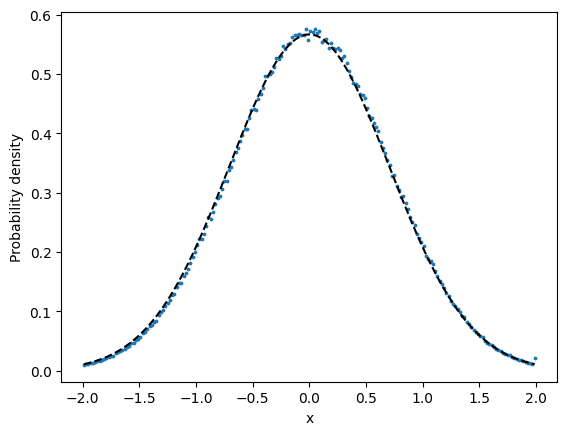

In [7]:
# Generating Paths and calculating weight of each path
paths_prop = []
weights_prop = []
x_end_prop = []

for xN in x_endpoints_prop:
    for _ in range(numb_paths_prop):
        p = Pos_Gen_prop(x_0_prop, xN, steps_prop)
        S = action_harmonic_prop(p, times_prop, mass_prop)
        w = np.exp(-S)
        paths_prop.append(p)
        weights_prop.append(w)
        x_end_prop.append(xN)

paths_prop = np.array(paths_prop)
weights_prop = np.array(weights_prop)
x_end_prop = np.array(x_end_prop)

print(paths_prop[0])
print(len(paths_prop))
print(len(paths_prop))
print(paths_prop[999:1001])

# Finding the groundstate wave function of the path
x_bins_prop = np.linspace(-2, 2, 201)

pdf_unnormalised_prop, bin_edges_prop = np.histogram(x_end_prop, bins=x_bins_prop, weights=weights_prop)
x_centres_prop = 0.5 * (bin_edges_prop[1:] + bin_edges_prop[:-1])
dx_prop = np.diff(x_bins_prop)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area_prop = np.sum(pdf_unnormalised_prop * dx_prop)
pdf_prop = pdf_unnormalised_prop / (area_prop)

# --- Analytic PDF for comparison (half side only) ---
phi_sq_analytic_prop = (1 / np.sqrt(np.pi)) * np.exp(-x_centres_prop ** 2)
phi_sq_analytic_prop /= np.sum(phi_sq_analytic_prop * dx_prop)  # normalize area to 0.5

# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_prop * dx_prop):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_prop * dx_prop):.5f}")

plt.figure(1)
plt.scatter(x_centres_prop, pdf_prop, label='Path integral estimate', s=3)
plt.plot(x_centres_prop, phi_sq_analytic_prop, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.show()

# Metropolis Data

Thermalizing...


Thermalising:  23%|██▎       | 114/500 [00:00<00:00, 597.57it/s]

Endpoint acceptance ≈ 0.493
Endpoint acceptance ≈ 0.520


Thermalising:  63%|██████▎   | 316/500 [00:00<00:00, 543.07it/s]

Endpoint acceptance ≈ 0.529
Endpoint acceptance ≈ 0.542


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 587.97it/s]


Endpoint acceptance ≈ 0.511

Sampling...


Sampling:   0%|          | 12/5000 [00:00<00:09, 547.35it/s]

Endpoint acceptance ≈ 0.513


Sampling:   2%|▏         | 112/5000 [00:00<00:09, 522.33it/s]

Endpoint acceptance ≈ 0.530


Sampling:   4%|▍         | 211/5000 [00:00<00:08, 541.20it/s]

Endpoint acceptance ≈ 0.541


Sampling:   6%|▋         | 315/5000 [00:00<00:07, 626.92it/s]

Endpoint acceptance ≈ 0.518


Sampling:   8%|▊         | 414/5000 [00:00<00:08, 552.60it/s]

Endpoint acceptance ≈ 0.528


Sampling:  10%|█         | 514/5000 [00:00<00:07, 563.12it/s]

Endpoint acceptance ≈ 0.525


Sampling:  12%|█▏        | 610/5000 [00:01<00:07, 568.94it/s]

Endpoint acceptance ≈ 0.540


Sampling:  14%|█▍        | 717/5000 [00:01<00:07, 572.47it/s]

Endpoint acceptance ≈ 0.524


Sampling:  16%|█▌        | 812/5000 [00:01<00:07, 557.74it/s]

Endpoint acceptance ≈ 0.518


Sampling:  18%|█▊        | 911/5000 [00:01<00:07, 519.75it/s]

Endpoint acceptance ≈ 0.506


Sampling:  20%|██        | 1015/5000 [00:01<00:06, 616.31it/s]

Endpoint acceptance ≈ 0.519


Sampling:  22%|██▏       | 1113/5000 [00:01<00:06, 598.77it/s]

Endpoint acceptance ≈ 0.548


Sampling:  24%|██▍       | 1215/5000 [00:02<00:06, 540.79it/s]

Endpoint acceptance ≈ 0.543


Sampling:  26%|██▌       | 1311/5000 [00:02<00:06, 528.15it/s]

Endpoint acceptance ≈ 0.538


Sampling:  28%|██▊       | 1408/5000 [00:02<00:06, 530.70it/s]

Endpoint acceptance ≈ 0.527


Sampling:  30%|███       | 1503/5000 [00:02<00:08, 397.58it/s]

Endpoint acceptance ≈ 0.508


Sampling:  34%|███▍      | 1703/5000 [00:03<00:05, 568.18it/s]

Endpoint acceptance ≈ 0.510
Endpoint acceptance ≈ 0.540


Sampling:  38%|███▊      | 1892/5000 [00:03<00:05, 567.07it/s]

Endpoint acceptance ≈ 0.513


Sampling:  40%|███▉      | 1983/5000 [00:03<00:08, 336.89it/s]

Endpoint acceptance ≈ 0.538


Sampling:  41%|████      | 2056/5000 [00:03<00:09, 318.99it/s]

Endpoint acceptance ≈ 0.498


Sampling:  43%|████▎     | 2173/5000 [00:04<00:05, 521.70it/s]

Endpoint acceptance ≈ 0.497


Sampling:  46%|████▌     | 2298/5000 [00:04<00:05, 531.86it/s]

Endpoint acceptance ≈ 0.526


Sampling:  48%|████▊     | 2410/5000 [00:04<00:04, 520.78it/s]

Endpoint acceptance ≈ 0.512
Endpoint acceptance ≈ 0.520


Sampling:  52%|█████▏    | 2614/5000 [00:05<00:04, 590.03it/s]

Endpoint acceptance ≈ 0.533
Endpoint acceptance ≈ 0.539


Sampling:  56%|█████▋    | 2824/5000 [00:05<00:03, 611.31it/s]

Endpoint acceptance ≈ 0.539
Endpoint acceptance ≈ 0.538


Sampling:  60%|██████    | 3024/5000 [00:05<00:02, 707.86it/s]

Endpoint acceptance ≈ 0.544
Endpoint acceptance ≈ 0.533


Sampling:  65%|██████▍   | 3229/5000 [00:06<00:02, 641.28it/s]

Endpoint acceptance ≈ 0.532
Endpoint acceptance ≈ 0.538


Sampling:  69%|██████▊   | 3429/5000 [00:06<00:02, 670.57it/s]

Endpoint acceptance ≈ 0.530
Endpoint acceptance ≈ 0.514


Sampling:  73%|███████▎  | 3631/5000 [00:06<00:02, 665.27it/s]

Endpoint acceptance ≈ 0.503
Endpoint acceptance ≈ 0.516


Sampling:  77%|███████▋  | 3827/5000 [00:07<00:01, 633.48it/s]

Endpoint acceptance ≈ 0.522
Endpoint acceptance ≈ 0.527


Sampling:  81%|████████  | 4035/5000 [00:07<00:01, 671.53it/s]

Endpoint acceptance ≈ 0.544
Endpoint acceptance ≈ 0.545


Sampling:  85%|████████▍ | 4231/5000 [00:07<00:01, 676.86it/s]

Endpoint acceptance ≈ 0.538
Endpoint acceptance ≈ 0.500


Sampling:  89%|████████▊ | 4432/5000 [00:08<00:00, 711.56it/s]

Endpoint acceptance ≈ 0.539
Endpoint acceptance ≈ 0.514


Sampling:  93%|█████████▎| 4630/5000 [00:08<00:00, 662.41it/s]

Endpoint acceptance ≈ 0.520
Endpoint acceptance ≈ 0.555


Sampling:  97%|█████████▋| 4830/5000 [00:08<00:00, 591.92it/s]

Endpoint acceptance ≈ 0.549
Endpoint acceptance ≈ 0.540


Sampling: 100%|██████████| 5000/5000 [00:08<00:00, 559.48it/s]


Endpoint acceptance ≈ 0.515

------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.7016 (expected ≈ 0.707)
Root mean square: 0.7016 (expected ≈ 0.707)


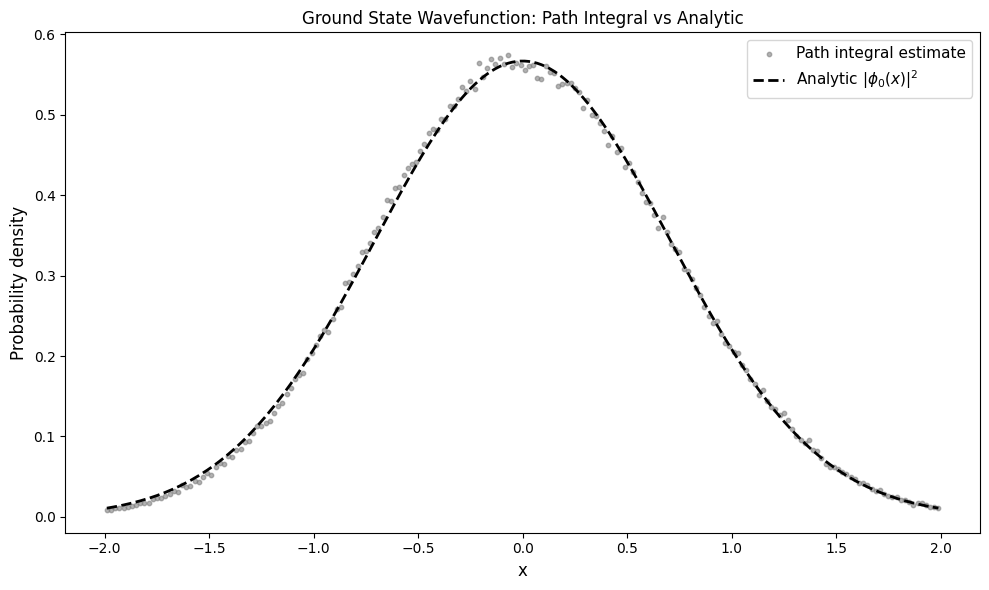

In [8]:
paths_x = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

paths_orig = paths_x.copy()
C = 1.8437008005694266
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x ** 2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color='grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black', linestyle='--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

# Bootstrapping

In [9]:
def chi_squared(model_params, model, x_data, y_data, y_err):
    residuals = (y_data - model(x_data, *model_params)) / y_err
    chi2 = np.sum(residuals**2)
    return chi2


def gaussian_model(x,A,B):
    return A*np.exp(B*x**2)

In [10]:
#Bootstrapping Metropolis

from tqdm.auto import trange
import numpy as np

def metropolis_pdf_bootstrap(
    n_bootstraps,
    numb_paths,
    steps,
    dt,
    times,
    mass,
    x_potential,
    sigma_prop,
    x_bins,
    n_therm=500,
    n_sample=5000,
    thin=10,
):

    dx = np.diff(x_bins)[0]
    x_centres = 0.5 * (x_bins[1:] + x_bins[:-1])

    pdfs = []

    for b in trange(n_bootstraps, desc="Bootstrap runs"):
        # --- fresh paths ---
        paths_x = np.array([
            MA.Pos_Gen(0.0, 0.0, steps, dt)
            for _ in range(numb_paths)
        ])

        # --- thermalisation ---
        for _ in range(n_therm):
            MA.metropolis_sweep_vectorised(
                paths_x, times, mass, x_potential, sigma_prop
            )

        # --- sampling ---
        samples_x = []

        for k in range(n_sample):
            MA.metropolis_sweep_vectorised(
                paths_x, times, mass, x_potential, sigma_prop
            )

            if k % thin == 0:
                samples_x.append(paths_x[:, -1].copy())

        samples_x = np.concatenate(samples_x)

        # --- PDF ---
        hist, _ = np.histogram(samples_x, bins=x_bins)
        pdf = hist / np.sum(hist * dx)

        pdfs.append(pdf)

    pdfs = np.array(pdfs)

    # --- statistics across runs ---
    pdf_mean = np.mean(pdfs, axis=0)
    pdf_se   = np.std(pdfs, axis=0, ddof=1) / np.sqrt(n_bootstraps)

    return x_centres, pdf_mean, pdf_se

def bootstrap_propagator_pdf(
    x_end_prop,
    weights_prop,
    x_bins_prop,
    n_bootstrap=1000
):
    """
    Bootstrap the propagator PDF from weighted paths.

    Returns:
        x_centres: array
        pdf_mean: array
        pdf_se: array
    """
    dx = np.diff(x_bins_prop)[0]
    x_centres = 0.5 * (x_bins_prop[1:] + x_bins_prop[:-1])

    pdfs = []

    n_paths = len(x_end_prop)
    for _ in trange(n_bootstrap, desc="Bootstrap propagator"):
        # Resample indices with replacement
        indices = np.random.choice(n_paths, size=n_paths, replace=True)
        x_resample = x_end_prop[indices]
        w_resample = weights_prop[indices]

        # Weighted histogram
        hist, _ = np.histogram(x_resample, bins=x_bins_prop, weights=w_resample)
        pdf = hist / np.sum(hist * dx)
        pdfs.append(pdf)

    pdfs = np.array(pdfs)
    pdf_mean = np.mean(pdfs, axis=0)
    pdf_se   = np.std(pdfs, axis=0, ddof=1)

    return x_centres, pdf_mean, pdf_se


In [11]:
x_bins = np.linspace(-2, 2, 201)

x_centres, pdf_mean, pdf_se = metropolis_pdf_bootstrap(
    n_bootstraps=100,
    numb_paths=numb_paths,
    steps=steps,
    dt=dt,
    times=times,
    mass=mass,
    x_potential=x_potential,
    sigma_prop=sigma_prop,
    x_bins=x_bins,
    n_therm=500,
    n_sample=5000,
    thin=10,
)

Bootstrap runs: 100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


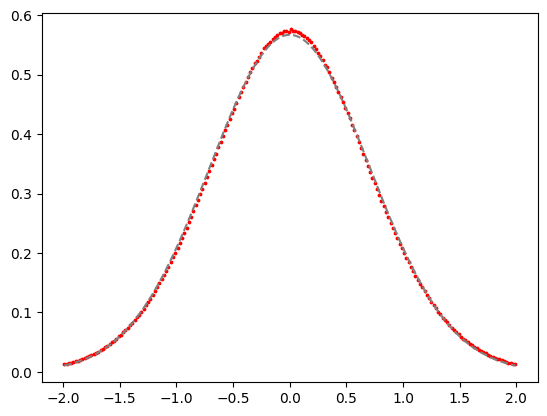

In [12]:
plt.figure(1)
plt.scatter(x_centres, pdf_mean, s = 3, color = "red")
plt.plot(x_centres, phi_sq_analytic_x, 'grey', linestyle = "--")
plt.show()

In [13]:
x_centres_prop_boot, pdf_mean_prop, pdf_se_prop = bootstrap_propagator_pdf(
    x_end_prop,
    weights_prop,
    x_bins_prop,
    n_bootstrap=500  # tune as desired
)


Bootstrap propagator: 100%|██████████| 500/500 [00:04<00:00, 114.33it/s]


In [14]:
#residuals for propagator

propagator_residuals_normalised = (pdf_mean_prop - phi_sq_analytic_x)/pdf_se_prop
print(np.std(propagator_residuals_normalised))

#residuals for metropolis

metropolis_residiuals_normalised = (pdf_mean - phi_sq_analytic_x)/pdf_se
print(np.std(metropolis_residiuals_normalised))

1.5716203620681224
4.311422173712141


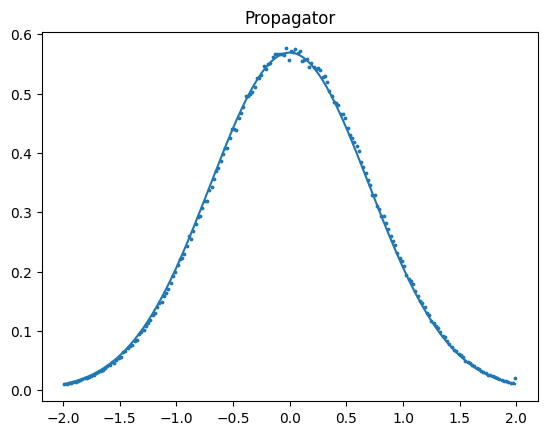

----- Propagator -----
A = 0.569 ± 0.000
B = -1.012 ± 0.000
Red_chi2 = 2.3156
----- ----- ----- -----


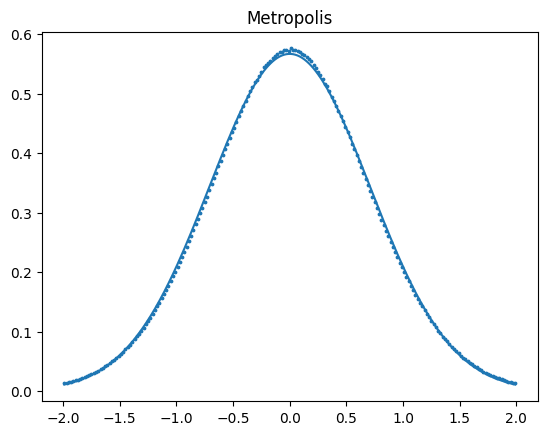

----- Metropolis -----
A = 0.567 ± 0.000
B = -0.996 ± 0.000
Red_chi2 = 19.2279
----- ----- ----- -----


In [15]:
# goodness of fit testing
p0_gaussian = [0.505,1]

popt_prop, cov_prop = curve_fit(gaussian_model,
                                x_centres,
                                pdf_prop,
                                sigma = pdf_se_prop,
                                absolute_sigma = True,
                                p0 = p0_gaussian)

popt_metrop, cov_metrop = curve_fit(gaussian_model,
                                    x_centres,
                                    pdf_mean,
                                    sigma = pdf_se,
                                    absolute_sigma= True,
                                    p0 = p0_gaussian)

chi2_metrop = chi_squared(
    popt_metrop,
    gaussian_model,
    x_data=x_centres,
    y_data=pdf_mean,
    y_err=pdf_se
)
dof_metrop = len(x_centres) - len(popt_metrop)

red_chi2_metrop = chi2_metrop/dof_metrop

chi2_prop = chi_squared(
    popt_prop,
    gaussian_model,
    x_data=x_centres,
    y_data=pdf_mean_prop,
    y_err=pdf_se_prop
)
dof_prop = len(x_centres) - len(popt_prop)

red_chi2_prop = chi2_prop/dof_prop

plt.figure(1)
plt.title("Propagator")
plt.scatter(x_centres,pdf_prop, s =3)
plt.plot(x_centres,gaussian_model(x_centres,*popt_prop))
plt.show()
print(f"----- Propagator -----")
print(f"A = {popt_prop[0]:.3f} ± {np.std(cov_prop[0][0]):.3f}")
print(f"B = {popt_prop[1]:.3f} ± {np.std(cov_prop[1][1]):.3f}")
print(f"Red_chi2 = {red_chi2_prop:.4f}")
print(f"----- ----- ----- -----")

plt.figure(2)
plt.title("Metropolis")
plt.scatter(x_centres,pdf_mean, s =3)
plt.plot(x_centres,gaussian_model(x_centres,*popt_metrop))
plt.show()
print(f"----- Metropolis -----")
print(f"A = {popt_metrop[0]:.3f} ± {np.std(cov_metrop[0][0]):.3f}")
print(f"B = {popt_metrop[1]:.3f} ± {np.std(cov_metrop[1][1]):.3f}")
print(f"Red_chi2 = {red_chi2_metrop:.4f}")
print(f"----- ----- ----- -----")

# Other shit Im not sure about

In [46]:
def model_pdf(x, B, dx):
    unnorm = np.exp(B * x**2)
    A = 1.0 / np.sum(unnorm * dx)
    return A * unnorm

def neg_log_likelihood(B, x, pdf_data, dx):
    pdf_model = model_pdf(x, B, dx)

    mask = pdf_data > 0
    return np.sum(
        pdf_data[mask] * np.log(pdf_data[mask] / pdf_model[mask])
    ) * dx


In [30]:
#model fitting

from scipy.optimize import minimize

dx = x_centres[1] - x_centres[0]

res_prop = minimize(
    neg_log_likelihood,
    x0=-1.0,
    args=(x_centres, pdf_prop, dx)
)

res_metro = minimize(
    neg_log_likelihood,
    x0=-1.0,
    args=(x_centres, pdf_x, dx)
)

B_prop = res_prop.x[0]
B_metro = res_metro.x[0]

print(f"B (propagator) = {B_prop:.6f}")
print(f"B (metropolis) = {B_metro:.6f}")


B (propagator) = -1.012434
B (metropolis) = -0.982662


In [31]:
def bootstrap_B(x, pdf, dx, n_boot=500):
    Bs = []
    for _ in range(n_boot):
        noise = np.random.normal(0, np.sqrt(pdf / np.sum(pdf)), size=pdf.size)
        pdf_boot = pdf + noise
        pdf_boot = np.clip(pdf_boot, 0, None)
        pdf_boot /= np.sum(pdf_boot * dx)

        res = minimize(
            neg_log_likelihood,
            x0=-1.0,
            args=(x, pdf_boot, dx)
        )
        Bs.append(res.x[0])
    return np.array(Bs)

Bs_prop = bootstrap_B(x_centres, pdf_prop, dx)
Bs_metro = bootstrap_B(x_centres, pdf_x, dx)

print("Propagator: ", Bs_prop.mean(), Bs_prop.std())
print("Metropolis: ", Bs_metro.mean(), Bs_metro.std())


Propagator:  -1.0028614874023436 0.030042857776806042
Metropolis:  -0.9745729221969635 0.029707850982850503


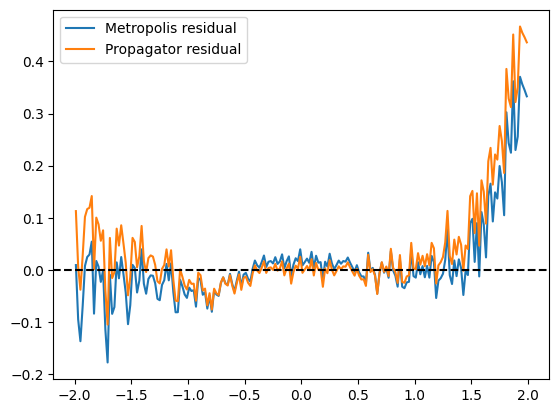

In [34]:
KL_prop = neg_log_likelihood(B_prop, x_centres, pdf_prop, dx)
KL_metro = neg_log_likelihood(B_metro, x_centres, pdf_x, dx)

plt.plot(
    x_centres,
    np.log(pdf_x) - np.log(model_pdf(x_centres, B_metro, dx)),
    label="Metropolis residual"
)
plt.plot(
    x_centres,
    np.log(pdf_x) - np.log(model_pdf(x_centres, B_prop, dx)),
    label="Propagator residual"
)
plt.axhline(0, color='k', ls='--')
plt.legend()


Bootstrapping: 100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


B = -0.964090
σ_B = 0.002023
68% CI = [-0.966113, -0.962109]


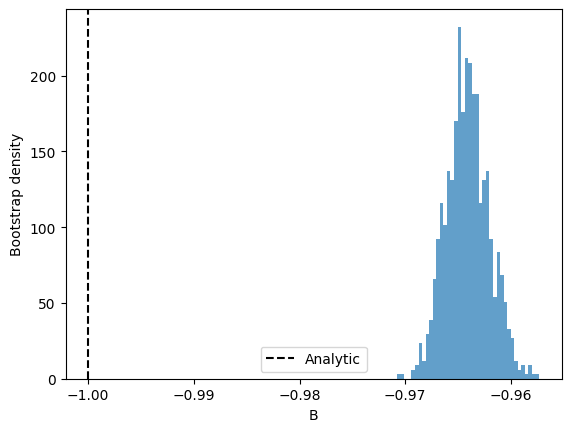

In [39]:
def neg_log_likelihood_raw(B, samples):
    # evaluate model on the samples themselves
    pdf_vals = np.exp(B * samples**2)

    # normalisation constant
    # (compute on a fine grid for stability)
    x_grid = np.linspace(-5, 5, 4001)
    Z = np.trapezoid(np.exp(B * x_grid**2), x_grid)

    return -np.sum(np.log(pdf_vals / Z))

def bootstrap_B_raw(samples, n_boot=1000):
    N = len(samples)
    B_boot = np.empty(n_boot)

    for i in trange(n_boot, desc="Bootstrapping"):
        # resample with replacement
        boot_samples = np.random.choice(samples, size=N, replace=True)

        res = minimize(
            neg_log_likelihood_raw,
            x0=-1.0,
            args=(boot_samples,),
            method="Nelder-Mead"
        )

        B_boot[i] = res.x[0]

    return B_boot

B_boot = bootstrap_B_raw(samples_x, n_boot=1000)

B_mean = np.mean(B_boot)
B_std  = np.std(B_boot)
B_ci   = np.percentile(B_boot, [16, 84])

print(f"B = {B_mean:.6f}")
print(f"σ_B = {B_std:.6f}")
print(f"68% CI = [{B_ci[0]:.6f}, {B_ci[1]:.6f}]")

plt.hist(B_boot, bins=40, density=True, alpha=0.7)
plt.axvline(-1, color='k', ls='--', label='Analytic')
plt.xlabel("B")
plt.ylabel("Bootstrap density")
plt.legend()
plt.show()


# Calculations for plot

In [88]:
#SE ribbon for propagator
y_max_prop = gaussian_model(x_centres, popt_prop[0] + np.sqrt(cov_prop[0][0]), popt_prop[1] + np.sqrt(cov_prop[1][1]))
y_min_prop = gaussian_model(x_centres, popt_prop[0] - np.sqrt(cov_prop[0][0]), popt_prop[1] - np.sqrt(cov_prop[1][1]))

#SE ribbon for metropolis
y_max_metrop = gaussian_model(x_centres, popt_metrop[0] + np.sqrt(cov_metrop[0][0]), popt_metrop[1] + np.sqrt(cov_metrop[1][1]))
y_min_metrop = gaussian_model(x_centres, popt_metrop[0] - np.sqrt(cov_metrop[0][0]), popt_metrop[1] - np.sqrt(cov_metrop[1][1]))

In [89]:
print(len(pdf_mean))
print(len(pdf_mean_prop))

def bin_by_4(x, y, yerr, bin_size=4):
    n_bins = len(x) // bin_size

    x_b = x[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
    y_b = y[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
    yerr_b = np.sqrt(
        (yerr[:n_bins * bin_size].reshape(n_bins, bin_size) ** 2).sum(axis=1)
    ) / bin_size

    return x_b, y_b, yerr_b

200
200


In [90]:
x_binned, pdf_binned_metrop, pdf_binned_metrop_err = bin_by_4(x_centres, pdf_mean, pdf_se)

x_binned, pdf_binned_prop, pdf_binned_prop_err = bin_by_4(x_centres, pdf_mean_prop, pdf_se_prop)

x_binned, pdf_analytic_binned, filler = bin_by_4(x_centres, phi_sq_analytic_x, pdf_se)

x_binned, y_max_prop_binned, filler = bin_by_4(x_centres, y_max_prop, pdf_se)

x_binned, y_min_prop_binned, filler = bin_by_4(x_centres, y_min_prop, pdf_se)

x_binned, y_max_metrop_binned, filler = bin_by_4(x_centres, y_max_metrop, pdf_se)

x_binned, y_min_metrop_binned, filler = bin_by_4(x_centres, y_min_metrop, pdf_se)

#residuals for propagator

binned_propagator_residuals_normalised = (pdf_binned_prop - pdf_analytic_binned)/pdf_binned_prop_err
print(np.std(binned_propagator_residuals_normalised))

#residuals for metropolis

binned_metropolis_residuals_normalised = (pdf_binned_metrop - pdf_analytic_binned)/pdf_binned_metrop_err
print(np.std(binned_metropolis_residuals_normalised))

2.219652349679108
8.516018151235397


# Main Plot

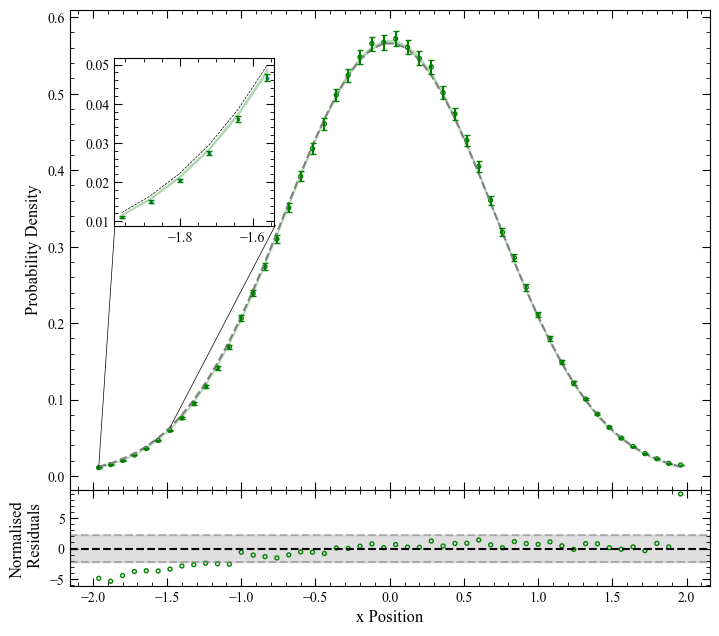

200
50


In [91]:
#plot for propagator

laptop_savepath_main_results_propagator = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\main_results_propagator.svg"
pc_savepath_main_results_propagator = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\main_results_propagator.svg"

fig = plt.figure(1)

#main plot 1
fig.add_axes([0,0,1,1])
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.plot(x_binned, pdf_analytic_binned, linestyle = "--", color = "grey", label = "Theoretical")

plt.scatter(x_binned, pdf_binned_prop, marker = "o", s = 8, color = "green", facecolor = "none", label = "Propagator")
plt.errorbar(x_binned, pdf_binned_prop, yerr = pdf_binned_prop_err, linestyle = "none", color = "green", capsize = 2)

# plt.scatter(x_centres[-1], pdf_mean_prop[-1], marker = "o", s = 8, color = "red", label = "Outlier")

plt.fill_between(x_binned, y_max_prop_binned, y_min_prop_binned, color = "green", alpha = 0.2, label = "Se Ribbon")

plt.ylabel("Probability Density", fontsize=12)


#Inset
start_index = 0
end_index = 6
plt.plot([x_binned[start_index],-1.85],[pdf_analytic_binned[start_index], 0.333], color = 'black', linewidth = 0.5) #left line
plt.plot([x_binned[end_index],-0.77],[pdf_analytic_binned[end_index], 0.328], color = 'black', linewidth = 0.5) #right line

inset = fig.add_axes([0.07, 0.55, 0.25, 0.35])

inset.errorbar(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index],yerr = pdf_binned_prop_err[start_index:end_index], color = "green", linestyle ='none', capsize = 2) #error bars
inset.plot(x_binned[start_index:end_index],pdf_analytic_binned[start_index:end_index], color = 'black', linewidth = 0.5, linestyle = "--") #analytic
inset.scatter(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index], s=3) #data

inset.fill_between(x_binned[start_index:end_index],y_min_prop_binned[start_index:end_index], y_max_prop_binned[start_index:end_index], color = "green", alpha = 0.2) #se ribbon

inset.minorticks_on()
inset.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
inset.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')


#residual plot 1
rp1 = fig.add_axes(([0,-0.2,1,0.2]))
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp1.axhline(0, color = 'black', linestyle = '--')
rp1.axhline(np.std(binned_propagator_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhline(-np.std(binned_propagator_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhspan(-np.std(binned_propagator_residuals_normalised), np.std(binned_propagator_residuals_normalised), color='grey', alpha=0.25)

plt.scatter(x_binned, binned_propagator_residuals_normalised, marker = "o", s = 8, color = "green", facecolor = "none")

plt.xlabel("x Position", fontsize=12)
rp1.set_ylabel("Normalised \n Residuals",fontsize=12)
# rp1.yaxis.set_label_coords(-0.05,1)


plt.savefig(pc_savepath_main_results_propagator, bbox_inches = 'tight')
plt.show()

print(len(phi_sq_analytic_x))
print(len(binned_propagator_residuals_normalised))

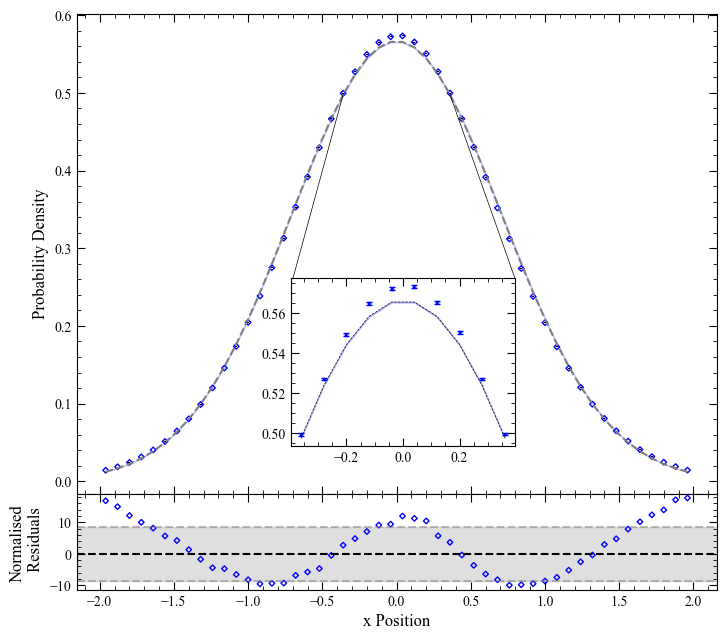

In [92]:
#plot for metropolis

laptop_savepath_main_results_metropolis = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\main_results_metropolis.svg"
pc_savepath_main_results_metropolis = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\main_results_metropolis.svg"

fig = plt.figure(1)

#main plot 2
plt2 = fig.add_axes([0,0,1,1])


plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.plot(x_binned, pdf_analytic_binned, linestyle = "--", color = "grey", label = "Theoretical")

plt.scatter(x_binned, pdf_binned_metrop, marker = "D", s = 8,color = "blue", facecolor = "none", label = "Metropolis")
plt.errorbar(x_binned, pdf_binned_metrop, yerr= pdf_binned_metrop_err, linestyle = "none", color = "black")
plt.fill_between(x_binned, y_max_metrop_binned, y_min_metrop_binned, color = "blue", alpha = 0.2)

plt.ylabel("Probability Density", fontsize=12)


#Inset
start_index = 20
end_index = 30
plt.plot([x_binned[start_index],-0.7],[pdf_analytic_binned[start_index], 0.26], color = 'black', linewidth = 0.5) #left line
plt.plot([x_binned[end_index-1],0.8],[pdf_analytic_binned[end_index-1], 0.26], color = 'black', linewidth = 0.5) #right line

inset = fig.add_axes([0.335, 0.1, 0.35, 0.35])

inset.errorbar(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index],yerr = pdf_binned_metrop_err[start_index:end_index], color = "blue", linestyle ='none', capsize = 2) #error bars
inset.plot(x_binned[start_index:end_index],pdf_analytic_binned[start_index:end_index], color = 'black',linestyle = "--", linewidth = 0.5) #analytic
inset.scatter(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index], s=3) #data

inset.fill_between(x_binned[start_index:end_index],y_min_metrop_binned[start_index:end_index], y_max_metrop_binned[start_index:end_index], color = "blue", alpha = 0.2) #se ribbon

inset.minorticks_on()
inset.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
inset.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')


#residual plot 2
rp2 = fig.add_axes(([0,-0.2,1,0.2]))

plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp2.axhline(0, color = 'black', linestyle = '--')
rp2.axhline(np.std(binned_metropolis_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhline(-np.std(binned_metropolis_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhspan(-np.std(binned_metropolis_residuals_normalised), np.std(binned_metropolis_residuals_normalised), color='grey', alpha=0.25)

plt.scatter(x_binned, binned_metropolis_residuals_normalised, marker = "D", s = 8,color = "blue", facecolor = "none")

plt.xlabel("x Position", fontsize=12)
plt.ylabel("Normalised \n Residuals",fontsize=12)

plt.savefig(pc_savepath_main_results_metropolis, bbox_inches = 'tight')
plt.show()

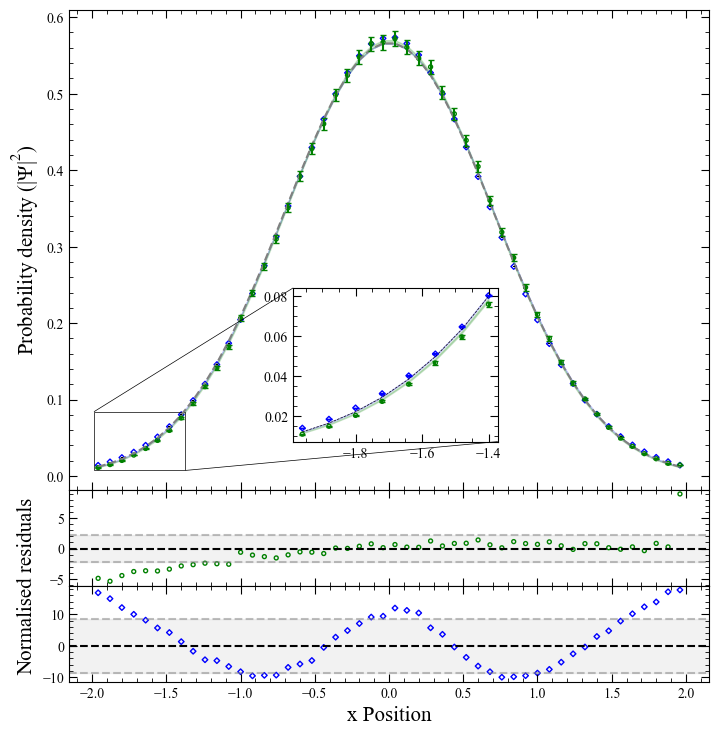

In [93]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#combined plot

#plot for metropolis

laptop_savepath_main_results_combined = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\main_results_combined.svg"
pc_savepath_main_results_combined = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\main_results_combined.svg"

fig = plt.figure(1)

#main plot 2
plt2 = fig.add_axes([0,0,1,1])


plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.plot(x_binned, pdf_analytic_binned, linestyle = "--", color = "grey", label = "Theoretical")

plt.scatter(x_binned, pdf_binned_metrop, marker = "D", s = 8,color = "blue", facecolor = "none", label = "Metropolis")
plt.errorbar(x_binned, pdf_binned_metrop, yerr= pdf_binned_metrop_err, linestyle = "none", color = "black")
plt.fill_between(x_binned, y_max_metrop_binned, y_min_metrop_binned, color = "blue", alpha = 0.2)

plt.scatter(x_binned, pdf_binned_prop, marker = "o", s = 8, color = "green", facecolor = "none", label = "Propagator")
plt.errorbar(x_binned, pdf_binned_prop, yerr = pdf_binned_prop_err, linestyle = "none", color = "green", capsize = 2)
plt.fill_between(x_binned, y_max_prop_binned, y_min_prop_binned, color = "green", alpha = 0.2, label = "Se Ribbon")

plt.ylabel(r"Probability density ($| \Psi |^2$)", fontsize=15)


# #Inset for centre
# start_index = 20
# end_index = 30
# inset = fig.add_axes([0.35, 0.1, 0.32, 0.32])
#
# mark_inset(plt2, inset, loc1=2, loc2=1, fc="none", ec="black", lw=0.5)
#
# inset.plot(x_binned[start_index:end_index],pdf_analytic_binned[start_index:end_index], color = 'black',linestyle = "--", linewidth = 0.5) #analytic
#
# inset.errorbar(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index],yerr = pdf_binned_metrop_err[start_index:end_index], color = "blue", linestyle ='none', capsize = 2) #error bars
# inset.scatter(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index], s=8, color = 'blue', marker = "D", facecolor = "none") #data
# inset.fill_between(x_binned[start_index:end_index],y_min_metrop_binned[start_index:end_index], y_max_metrop_binned[start_index:end_index], color = "blue", alpha = 0.2) #se ribbon
#
# inset.errorbar(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index],yerr = pdf_binned_prop_err[start_index:end_index], color = "green", linestyle ='none', capsize = 2) #error bars
# inset.scatter(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index], s=8, color = 'green', marker = "o", facecolor = "none") #data
# inset.fill_between(x_binned[start_index:end_index],y_min_prop_binned[start_index:end_index], y_max_prop_binned[start_index:end_index], color = "green", alpha = 0.2) #se ribbon

#Inset for bottom left
start_index = 0
end_index = 8
inset = fig.add_axes([0.35, 0.1, 0.32, 0.32])

mark_inset(plt2, inset, loc1=2, loc2=4, fc="none", ec="black", lw=0.5)

inset.plot(x_binned[start_index:end_index],pdf_analytic_binned[start_index:end_index], color = 'black',linestyle = "--", linewidth = 0.5) #analytic

inset.errorbar(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index],yerr = pdf_binned_metrop_err[start_index:end_index], color = "blue", linestyle ='none', capsize = 2) #error bars
inset.scatter(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index], s=8, color = 'blue', marker = "D", facecolor = "none") #data
inset.fill_between(x_binned[start_index:end_index],y_min_metrop_binned[start_index:end_index], y_max_metrop_binned[start_index:end_index], color = "blue", alpha = 0.2) #se ribbon

inset.errorbar(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index],yerr = pdf_binned_prop_err[start_index:end_index], color = "green", linestyle ='none', capsize = 2) #error bars
inset.scatter(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index], s=8, color = 'green', marker = "o", facecolor = "none") #data
inset.fill_between(x_binned[start_index:end_index],y_min_prop_binned[start_index:end_index], y_max_prop_binned[start_index:end_index], color = "green", alpha = 0.2) #se ribbon

inset.minorticks_on()
inset.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
inset.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

#residual plot 1
rp1 = fig.add_axes(([0,-0.2,1,0.2]))
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp1.axhline(0, color = 'black', linestyle = '--')
rp1.axhline(np.std(binned_propagator_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhline(-np.std(binned_propagator_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhspan(-np.std(binned_propagator_residuals_normalised), np.std(binned_propagator_residuals_normalised), color='grey', alpha=0.1)

plt.scatter(x_binned, binned_propagator_residuals_normalised, marker = "o", s = 8, color = "green", facecolor = "none")

plt.ylabel("Normalised residuals",fontsize=15)
rp1.yaxis.set_label_coords(-0.05,0)


#residual plot 2
rp2 = fig.add_axes(([0,-0.4,1,0.2]))

plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp2.axhline(0, color = 'black', linestyle = '--')
rp2.axhline(np.std(binned_metropolis_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhline(-np.std(binned_metropolis_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhspan(-np.std(binned_metropolis_residuals_normalised), np.std(binned_metropolis_residuals_normalised), color='grey', alpha=0.1)

plt.scatter(x_binned, binned_metropolis_residuals_normalised, marker = "D", s = 8,color = "blue", facecolor = "none")

plt.xlabel("x Position", fontsize=15)

plt.savefig(pc_savepath_main_results_combined, bbox_inches = 'tight')
plt.show()

199
199


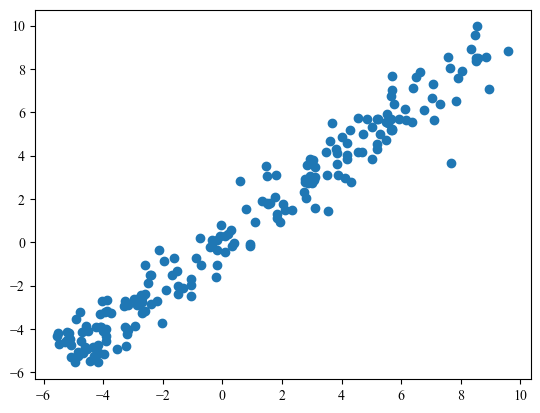

In [94]:
# lag plots

metropolis_ith = metropolis_residiuals_normalised[1:]
print(len(metropolis_ith))
metropolis_i_minus_one = metropolis_residiuals_normalised[0:199]
print(len(metropolis_i_minus_one))

plt.figure(1)
plt.scatter(metropolis_ith,metropolis_i_minus_one)

plt.show()

199
199


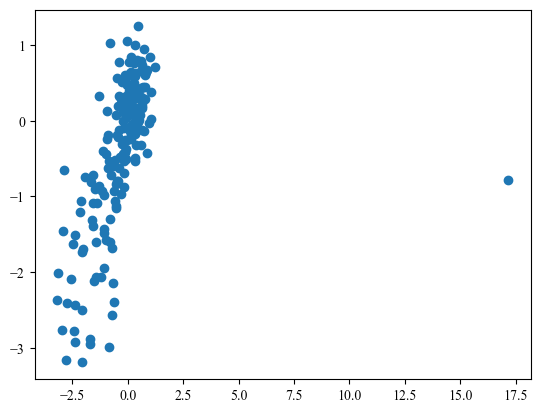

In [95]:
propagator_ith = propagator_residuals_normalised[1:]
print(len(propagator_ith))
propagator_i_minus_one = propagator_residuals_normalised[0:199]
print(len(propagator_i_minus_one))

plt.figure(1)
plt.scatter(propagator_ith,propagator_i_minus_one)

plt.show()

In [96]:
i_099 = np.searchsorted(x_centres, 0.99)
i_101 = np.searchsorted(x_centres, 1.01)

In [97]:
analytical = np.sum(phi_sq_analytic_x[i_099:i_101]*dx)
propagator = np.sum(gaussian_model(x_centres[i_099:i_101],*popt_prop)*dx)
metropolis = np.sum(gaussian_model(x_centres[i_099:i_101],*popt_metrop)*dx)

print(f"---- ---- Results Table ---- ----")
print(f"---- Probabilities ----")
print(f"analytical: {analytical}")
print(f"propagator: {propagator}")
print(f"metropolis: {metropolis}")

print(f"---- Red chi2 ----")
print(f"analytical: -")
print(f"propagator: {red_chi2_prop}")
print(f"metropolis: {red_chi2_metrop}")

print(f"---- A ----")
print(f"analytical: {1/np.sqrt(np.pi)}")
print(f"propagator: {popt_prop[0]} ± {np.sqrt(cov_prop[0][0])}")
print(f"metropolis: {popt_metrop[0]}")

print(f"---- A 95% CI----")
print(f"analytical: {1/np.sqrt(np.pi)}")
print(f"propagator: [{popt_prop[0]-1.96*np.sqrt(cov_prop[0][0])},{popt_prop[0]+1.96*np.sqrt(cov_prop[0][0])}]  ")
print(f"metropolis: [{popt_metrop[0]-1.96*np.sqrt(cov_metrop[0][0])},{popt_metrop[0]+1.96*np.sqrt(cov_metrop[0][0])}]")

print(f"---- B ----")
print(f"analytical: {-1}")
print(f"propagator: {popt_prop[1]}")
print(f"metropolis: {popt_metrop[1]}")

print(f"---- B 95% CI----")
print(f"analytical: {-1}")
print(f"propagator: [{popt_prop[1]+1.96*np.sqrt(cov_prop[1][1])},{popt_prop[1]-1.96*np.sqrt(cov_prop[1][1])}]  ")
print(f"metropolis: [{popt_metrop[1]+1.96*np.sqrt(cov_metrop[1][1])},{popt_metrop[1]-1.96*np.sqrt(cov_metrop[1][1])}]")

---- ---- Results Table ---- ----
---- Probabilities ----
analytical: 0.004254403892065026
propagator: 0.004221151767085054
metropolis: 0.004268822771068385
---- Red chi2 ----
analytical: -
propagator: 2.3155863785147166
metropolis: 19.227908221751747
---- A ----
analytical: 0.5641895835477563
propagator: 0.5691001324941362 ± 0.002045747157290047
metropolis: 0.5667609939021779
---- A 95% CI----
analytical: 0.5641895835477563
propagator: [0.5650904680658476,0.5731097969224247]  
metropolis: [0.566401881793416,0.5671201060109399]
---- B ----
analytical: -1
propagator: -1.0120654745396807
metropolis: -0.9964050508475037
---- B 95% CI----
analytical: -1
propagator: [-1.007814359159229,-1.0163165899201323]  
metropolis: [-0.995508588179697,-0.9973015135153105]


In [25]:
print(1/np.sqrt(np.pi))

0.5641895835477563


# Hypothesis Testing

In [100]:
from scipy.stats import kstest

# Example: your sampled positions
x_samples_metropolis = pdf_mean
x_samples_prop = pdf_mean_prop

# Analytical Gaussian parameters
mu_theory = 0.0
sigma_theory = 1/np.sqrt(2)  # ground-state harmonic oscillator

# Perform KS test
D_metropolis, p_value_metropolis = kstest(x_samples_metropolis, 'norm', args=(mu_theory, sigma_theory))
D_prop, p_value_prop = kstest(x_samples_prop, 'norm', args=(mu_theory, sigma_theory))

print(f"---- Propagator ----")
print(f"KS statistic: {D_prop}")
print(f"p-value: {p_value_prop}")

print(f"---- Metropolis ----")
print(f"KS statistic: {D_metropolis}")
print(f"p-value: {p_value_metropolis}")

---- Propagator ----
KS statistic: 0.5054407595415702
p-value: 7.593604574754907e-48
---- Metropolis ----
KS statistic: 0.5072147408520561
p-value: 3.3342702571371373e-48


In [101]:
from scipy.stats import anderson

# Standardize your data first
x_standardized_prop = (x_samples_prop - mu_theory) / sigma_theory
result_prop = anderson(x_standardized_prop, dist='norm')

x_standardized_metropolis = (x_samples_metropolis - mu_theory) / sigma_theory
result_metropolis = anderson(x_standardized_metropolis, dist='norm')

print(f"---- Propagator ----")
print("AD statistic:", result_prop.statistic)
print("Critical values:", result_prop.critical_values)
print("Significance levels (%):", result_prop.significance_level)

print(f"---- Metropolis ----")
print("AD statistic:", result_metropolis.statistic)
print("Critical values:", result_metropolis.critical_values)
print("Significance levels (%):", result_metropolis.significance_level)

---- Propagator ----
AD statistic: 7.514605850597263
Critical values: [0.565 0.644 0.772 0.901 1.071]
Significance levels (%): [15.  10.   5.   2.5  1. ]
---- Metropolis ----
AD statistic: 7.490152167189308
Critical values: [0.565 0.644 0.772 0.901 1.071]
Significance levels (%): [15.  10.   5.   2.5  1. ]
